### [Validation Curves](https://scikit-learn.org/stable/modules/learning_curve.html)

- Every estimator has tradeoffs. **Generalization error** can be decomposed into **bias, variance and noise**. 

- Bias is its average error for different training sets. 
- Variance indicates how sensitive it is to varying training sets. 
- Noise is a property of the data.

- Below: 

### [Example: Underfit/Overfit](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)

- We want to approximate a cosine function with models that have varying polynomial features. 

- A linear function (polynomial with degree 1) is not sufficient (underfitting). 

- A polynomial of degree 4 approximates the true function almost perfectly. 

- Higher-degree models overfit the training data (it learns the noise of the training data). 

- We calculate the mean squared error (MSE) on the validation set. Higher MSEs indicate the less likely the model generalizes correctly from the training data.

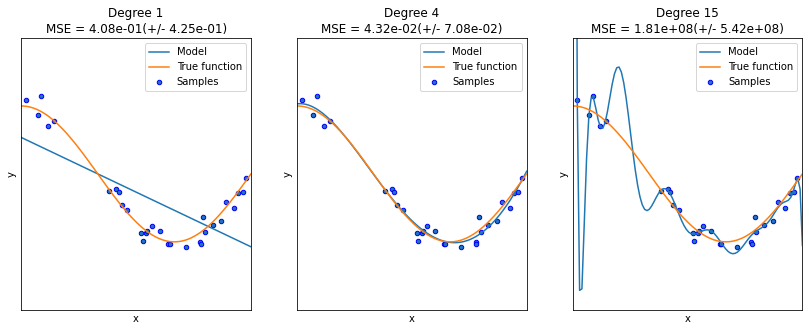

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))

### [Validation Curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html#sklearn.model_selection.validation_curve)

- To validate a model we need a scoring function. The best ways to choose multiple hyperparameters are grid search or similar methods. 

- If we optimized the hyperparameters based on a validation score, the validation score is biased and not a good estimate of the generalization any longer. To get a proper estimate of the generalization we have to compute the score on another test set.

- However, it is sometimes helpful to plot the influence of a single hyperparameter on the training & validation scores to learn if an estimator is overfitting or underfitting.

- If the training and validation scores are both low, the estimator is **underfitting**. If the training score is high and the validation score is low, the estimator is **overfitting** and otherwise it is working very well. A low training score and a high validation score is usually not possible.

In [2]:
import numpy as np
from sklearn.model_selection import validation_curve as VC
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

np.random.seed(0)
X, y    = load_iris(return_X_y=True)
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X, y    = X[indices], y[indices]

train_scores, valid_scores = VC(Ridge(), 
                                X, y, "alpha",
                                np.logspace(-7, 3, 3),
                                cv=5)
print(train_scores, valid_scores)

[[0.93402178 0.94366418 0.92648383 0.91933313 0.92922507]
 [0.9340217  0.94366412 0.92648377 0.91933304 0.929225  ]
 [0.51143526 0.52415737 0.49868907 0.47086988 0.49623503]] [[0.9055033  0.84185935 0.94569793 0.96231017 0.93366144]
 [0.90550088 0.84184574 0.94568969 0.96233172 0.93366806]
 [0.46706558 0.25698974 0.50496293 0.49826404 0.52500014]]


/home/bjpcjp/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=alpha, param_range=[1.e-07 1.e-02 1.e+03] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### [Example Validation Curve (SVM/Gamma)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html)

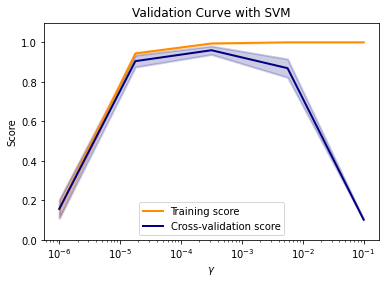

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve as VC

X, y        = load_digits(return_X_y=True)
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = VC(
    SVC(), X, y, 
    param_name="gamma", 
    param_range=param_range,
    scoring="accuracy", 
    n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, 
             label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, 
             test_scores_mean, 
             label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

### [Learning Curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve)

- A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It shows how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 

- 
For the naive Bayes, both the validation score and the training score converge to a value that is quite low with increasing size of the training set. Thus, we will probably not benefit much from more training data.

In contrast, for small amounts of data, the training score of the SVM is much greater than the validation score. Adding more training samples will most likely increase generalization.

### [Example: Learning Curve Analysis](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)

- Upper left: the learning curve of a naive Bayes classifier is shown for the digits dataset. The training & cross-validation score are both not very good at the end. 

- However, the shape of the curve is very common: the training score is high at the beginning and decreases; the cross-validation score is low at the beginning and increases. 

- Upper right: the learning curve of an SVM with RBF kernel. The training score is near the maximum and the validation score increass with more training samples. 

- 2nd row: Training times vs training dataset sizes. 

- 3rd row: Training times vs fit_times.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve as LC
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, 
                        X, y, 
                        axes=None, 
                        ylim=None, 
                        cv=None,
                        n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        LC(estimator, X, y, 
           cv=cv, 
           n_jobs=n_jobs,
           train_sizes=train_sizes,
           return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    fit_times_mean    = np.mean(fit_times, axis=1)
    fit_times_std     = np.std(fit_times, axis=1)

    axes[0].grid()
    axes[0].fill_between(train_sizes, 
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, 
                         alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, 
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, 
                         alpha=0.1,
                         color="g")
    axes[0].plot(        train_sizes, 
                         train_scores_mean, 
                         'o-', color="r",
                         label="Training score")
    axes[0].plot(        train_sizes, 
                         test_scores_mean, 
                         'o-', color="g",
                         label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, 
                 fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, 
                         fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, 
                         alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, 
                 test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, 
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, 
                         alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



<module 'matplotlib.pyplot' from '/home/bjpcjp/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

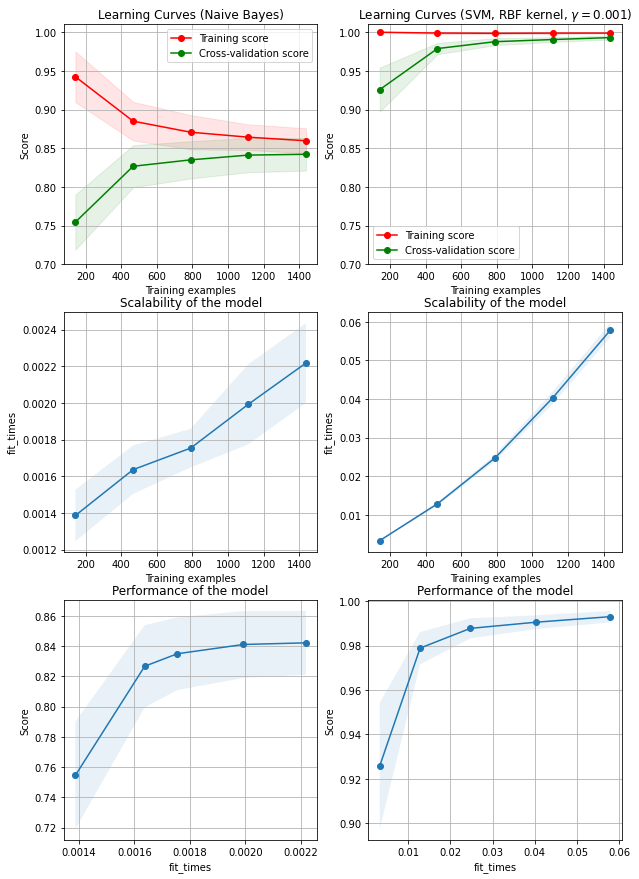

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()

title = "Learning Curves (Naive Bayes)"
plot_learning_curve(estimator, title, 
                    X, y, axes=axes[:, 0], 
                    ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

# SVC is more expensive so we do a lower number of CV iterations:

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
plot_learning_curve(estimator, title, 
                    X, y, axes=axes[:, 1], 
                    ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)